In [1]:
import numpy as np
import pyslsa
import matplotlib.pyplot as plt
%matplotlib inline
import neuraltda.topology2 as tp2
import neuraltda.simpComp as sc
import neuraltda.spectralAnalysis as sa

In [39]:
class TPEnv:
    
    def __init__(self, n_holes, hole_rad):
        self.xlim = [-1, 1]
        self.ylim = [-1, 1]
        self.holes = 0.75*(2*np.random.rand(n_holes, 2) - 1) # keep centers in range -1, 1
        self.hole_rad = hole_rad # radius of holes
        
    def in_hole(self, x, y):
        for hole in self.holes:
            if np.linalg.norm(np.subtract([x, y], hole)) < self.hole_rad:
                return True
        return False
        
 

In [33]:
def generate_paths(space, n_steps, ntrials, dl):
    # pick a starting point
    final_pts = np.zeros((ntrials, n_steps, 2))
    for trial in range(ntrials):
        pts = []
        pt = (2*np.random.rand(1, 2) - 1)[0]
        #pts.append(pt)
        steps_to_go = n_steps
        while steps_to_go > 0:

            # pick a new point
            theta = 2*np.pi*np.random.rand(1)[0]
            dx = dl*np.cos(theta)
            dy = dl*np.sin(theta)

            if (abs(pt[0]+dx) < 1 and 
               abs(pt[1]+dy) < 1 and
                not space.in_hole(pt[0]+dx, pt[1]+dy)):

                steps_to_go -= 1

                pt[0] = pt[0] + dx
                pt[1] = pt[1] + dy
                pts.append(np.copy(pt))
        pts = np.vstack(pts)
        final_pts[trial, :, :] = pts
    return final_pts

def generate_place_fields(n_fields, rad):
    
    centers =2*np.random.rand(n_fields, 2) - 1
    return (centers, rad)

def generate_spikes(paths, fields, max_rate, sigma):
    
    ncell, dim = fields.shape
    ntrial, nwin, _ = paths.shape
    
    spikes = np.zeros((ncell, nwin, ntrial))

    P1 = paths[:, :, np.newaxis, :]
    C1 = fields[np.newaxis, np.newaxis, :, :]

    P1 = np.tile(P1, [1, 1, ncell, 1])
    C1 = np.tile(C1, [ntrial, nwin, 1, 1])

    S = P1 - C1
    M = np.einsum('ijkl, ijkl->ijk', S, S)
    probs = max_rate*np.exp(-1*M / (2*sigma**2))
    spikes = 1*np.greater(probs, np.random.random(np.shape(probs)))
    return np.einsum('ijk->kji', spikes)

In [ ]:
test = TPEnv(1, 0.1)

In [ ]:
test.in_hole(-0.94, 0.2)

In [ ]:
test.holes

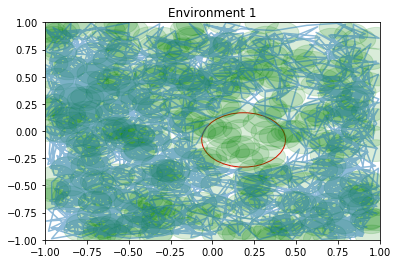

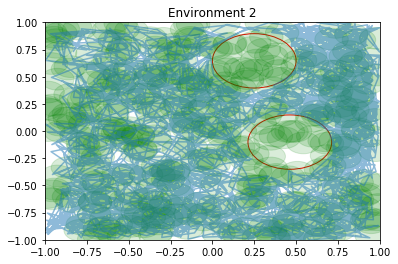

In [56]:
hole_rad = 0.25
nwin = 2000
ncells = 400
dl = 0.2
ntrials = 10
max_rate = 0.5
sigma = 0.1



env1 = TPEnv(1, hole_rad) # 1 hole
env2 = TPEnv(2, hole_rad) # 2 holes

pths1 = generate_paths(env1, nwin, ntrials, dl)  # 10 walks through environment 1
pths2 = generate_paths(env2, nwin, ntrials, dl)  # 10 walks through environment 2

(fields, rad) = generate_place_fields(ncells, sigma)


spikes1 = generate_spikes(pths1, fields, max_rate, sigma)
spikes2 = generate_spikes(pths2, fields, max_rate, sigma)


plt.figure()
plt.plot(pths1[0, :, 0], pths1[0, :, 1], alpha=0.5)
ax = plt.gca()
for hole in env1.holes:
    
    h1 = plt.Circle(hole, env1.hole_rad, fill=False, color='r')
    ax.add_artist(h1)
for field in fields:
    h2 = plt.Circle(field, 0.1, fill=True, color='g', alpha=0.15)
    ax.add_artist(h2)
plt.xlim([-1, 1])
plt.ylim([-1, 1])
plt.title('Environment 1')

plt.figure()
plt.plot(pths2[0, :, 0], pths2[0, :, 1], alpha=0.5)
ax = plt.gca()
for hole in env2.holes:
    
    h1 = plt.Circle(hole, env2.hole_rad, fill=False, color='r')
    ax.add_artist(h1)
for field in fields:
    h2 = plt.Circle(field, 0.1, fill=True, color='g', alpha=0.15)
    ax.add_artist(h2)
plt.xlim([-1, 1])
plt.ylim([-1, 1])
plt.title('Environment 2')

In [6]:
spikes.shape

(20, 2000, 10)

In [47]:
maxsimps = sc.binarytomaxsimplex(spikes[:, :, 0], rDup=True)
E = pyslsa.build_SCG(maxsimps)

In [45]:
avgfr = np.sum(spikes, axis=0)

In [46]:
avgfr[:, 0]

array([2, 2, 1, ..., 4, 4, 4])

In [57]:
# Build SCGs
env1_SCG = []
env2_SCG = []

for trial in range(ntrials):
    maxsimps1 = sc.binarytomaxsimplex(spikes1[:, :, trial], rDup=True)
    maxsimps2 = sc.binarytomaxsimplex(spikes2[:, :, trial], rDup=True)
    env1_SCG.append(pyslsa.build_SCG(maxsimps1))
    env2_SCG.append(pyslsa.build_SCG(maxsimps2))

In [61]:
#compute differences
import tqdm
beta = -1.0
dim = 2
SCGs = [env1_SCG, env2_SCG]

dists = np.zeros((2*ntrials, 2*ntrials))

for d1 in tqdm.tqdm(range(2*ntrials)):
    for d2 in range(d1, 2*ntrials):
        print(d1, d2)
        envA = int(d1 / ntrials)
        envB = int(d2 / ntrials)
        trialA = d1 % ntrials
        trialB = d2 % ntrials
        dists[d1, d2] = pyslsa.JS(SCGs[envA][trialA], SCGs[envB][trialB], dim, beta)

  0%|          | 0/20 [00:00<?, ?it/s]

0 0


KeyboardInterrupt: 

In [62]:
a = SCGs[0][0]
b = SCGs[0][1]
d = pyslsa.JS(a, b, dim, beta)

KeyboardInterrupt: 

In [ ]:
d